In [1]:
import timeit
start_time = timeit.default_timer()

In [2]:
## Import libraries
import time
import datetime
import pandas as pd
import io
import matplotlib.pyplot as plt

# GSEF forecast

In [3]:
gsef= pd.read_csv('gsef_output/historical_gsef.csv', parse_dates=['Date'], dayfirst=True)

This analysis demonstrates the use of ARIMA models to predict the prices of the NN (L) Global Sustainable Equity fund.

## Imports & data loading

In [4]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np

In [5]:
gsef_selected= gsef[['Date', 'Close']]

In [6]:
y = gsef_selected[['Close']].values

## Data splitting

In [7]:
train_data, test_data = gsef_selected[0:int(len(gsef_selected)*0.65)], gsef_selected[int(len(gsef_selected)*0.65):]

# Load/split your data
y_train, y_test = train_test_split(y, train_size= len(train_data))

## Pre-modeling analysis

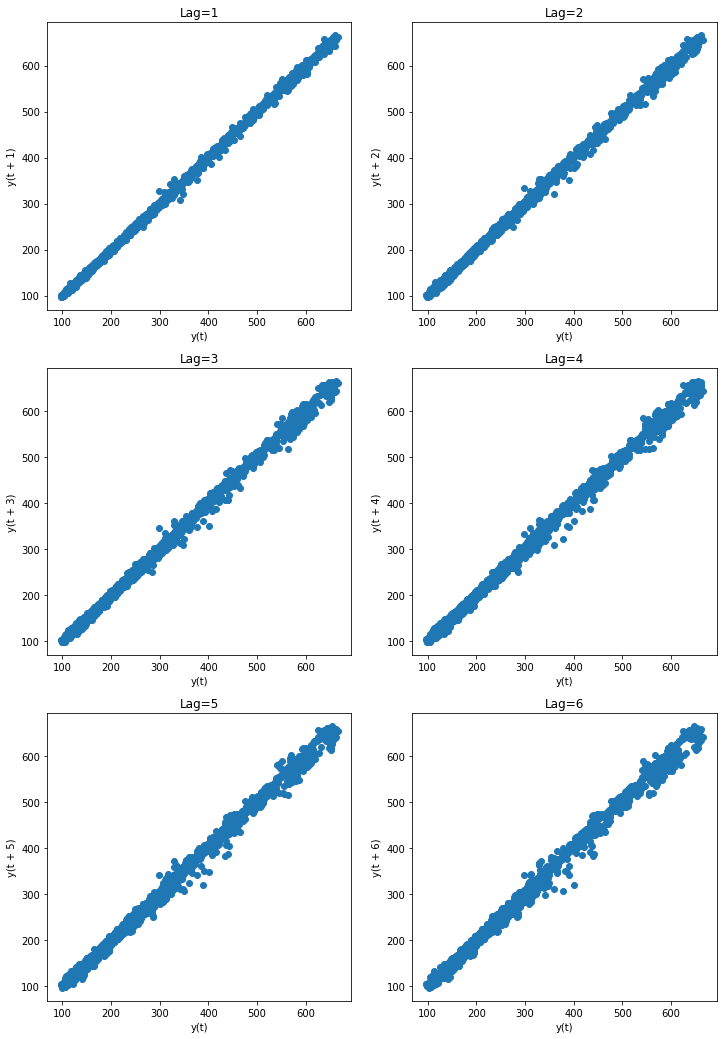

In [8]:
from pandas.plotting import lag_plot

fig, axes = plt.subplots(3, 2, figsize=(12, 18))
plt.title('GSEF Autocorrelation plot')

# The axis coordinates for the plots
ax_idcs = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 0),
    (2, 1)
]

for lag, ax_coords in enumerate(ax_idcs, 1):
    ax_row, ax_col = ax_coords
    axis = axes[ax_row][ax_col]
    lag_plot(gsef_selected['Close'], lag=lag, ax=axis)
    axis.set_title(f"Lag={lag}")

#plt.show()

## Estimating the differencing term

In [9]:
from pmdarima.arima import ndiffs

kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")

Estimated differencing term: 2


## Fitting our model

In [10]:
auto = pm.auto_arima(y_train, d=n_diffs, seasonal=True, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=2.62 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=16253.295, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=15420.874, Time=0.10 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.54 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=14993.669, Time=0.16 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=14773.622, Time=0.21 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=14678.894, Time=0.28 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=14608.936, Time=0.34 sec
 ARIMA(6,2,0)(0,0,0)[0]             : AIC=14511.642, Time=0.37 sec
 ARIMA(6,2,1)(0,0,0)[0]             : AIC=inf, Time=2.31 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=1.79 sec
 ARIMA(6,2,0)(0,0,0)[0] intercept   : AIC=14513.641, Time=0.67 sec

Best model:  ARIMA(6,2,0)(0,0,0)[0]          
Total fit time: 9.473 seconds


## Updating the model

In [11]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

model = auto  # seeded from the model we've already fit

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Mean absolute error: {mean_absolute_error(y_test, forecasts)}")

# Mean Absolute Percentage
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape= mean_absolute_percentage_error(y_test, forecasts) #same as MAE but percentage
print(f"Mean absolute percentage error:", mape)

print(f"Mean squared error: {mean_squared_error(y_test, forecasts)}")

print(f"SMAPE: {smape(y_test, forecasts)}")

Mean absolute error: 2.973806220848748
Mean absolute percentage error: 32.06126862638089
Mean squared error: 20.591362676106968
SMAPE: 0.807643479072639


In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5524
Model:               SARIMAX(6, 2, 0)   Log Likelihood              -13976.474
Date:                Mon, 23 May 2022   AIC                          27966.948
Time:                        23:40:52   BIC                          28013.264
Sample:                             0   HQIC                         27983.100
                               - 5524                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8638      0.005   -161.185      0.000      -0.874      -0.853
ar.L2         -0.6831      0.008    -86.768      0.000      -0.699      -0.668
ar.L3         -0.5820      0.009    -64.634      0.000      -0.600      -0.564
ar.L4         -0.4507      0.009    -51.440      0.000      -0.468      -0.434
ar.L5         -0.2830      0.007    -37.931      0.000      -0.298      -0.268
ar.L6         -0.2200      0.005    -43.073      0.000      -0.230      -0.210
sigma2         9.2435      0.067    137.547      0.000       9.112       9.375
===================================================================================
Ljung-Box (L1) (Q):                   2.51   Jarque-Bera (JB):             43011.67
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               5.81   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Viewing forecasts

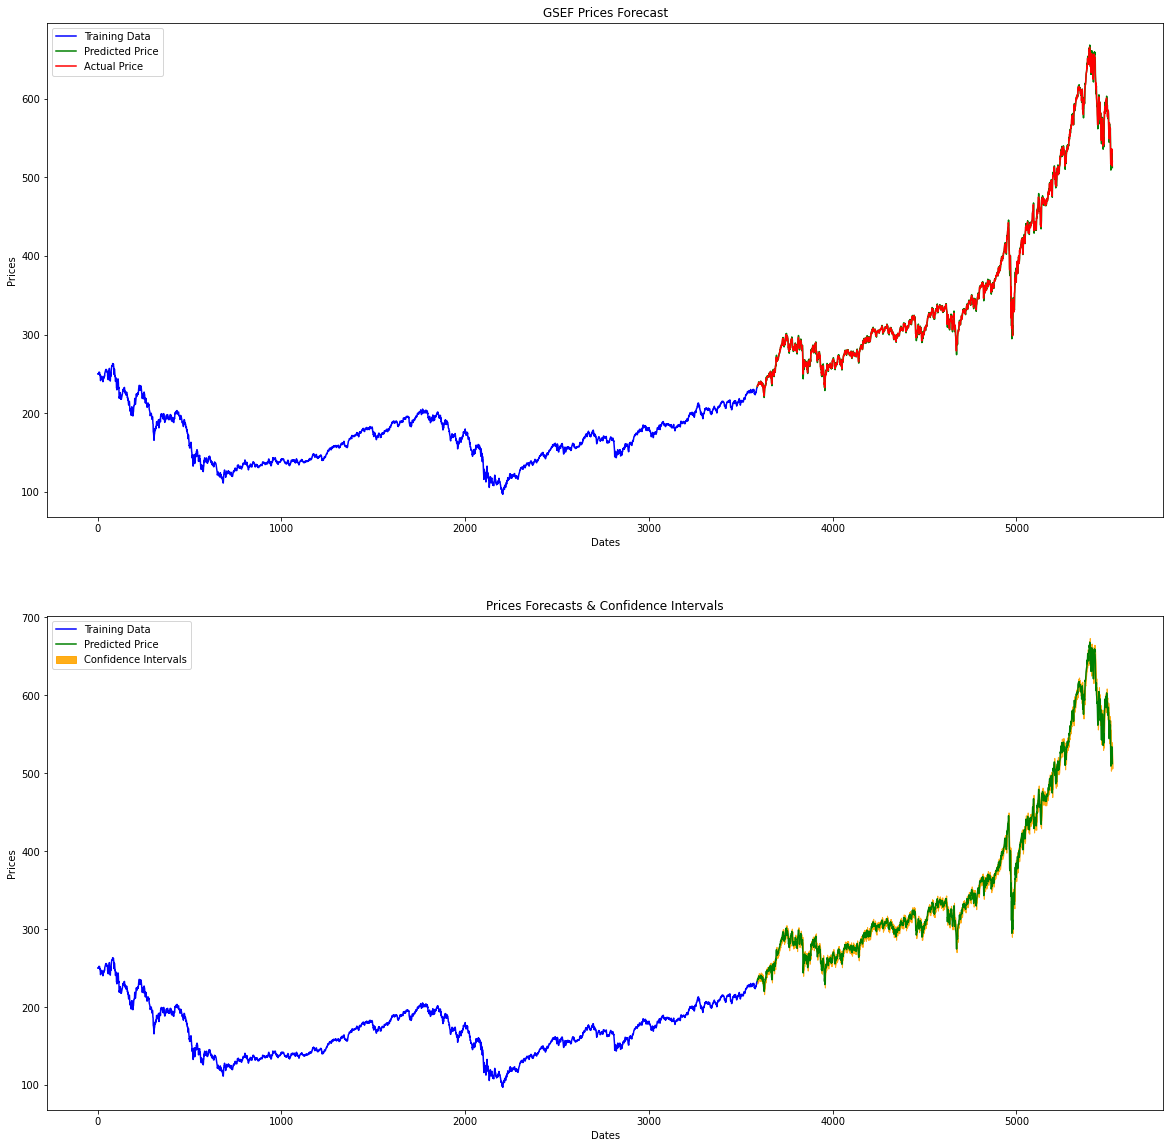

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(20, 20))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(y_train, color='blue', label='Training Data')
axes[0].plot(test_data.index, forecasts, color='green', label='Predicted Price')

axes[0].plot(test_data.index, y_test, color='red', label='Actual Price')
axes[0].set_title('GSEF Prices Forecast')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Prices')


axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(y_train, color='blue', label='Training Data')
axes[1].plot(test_data.index, forecasts, color='green',
             label='Predicted Price')

axes[1].set_title('Prices Forecasts & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(test_data.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

axes[1].legend()

## Forecast the Price for the next 10 business days

In [14]:
# Forecast the Price for the next 10 business days
forecast= model.predict(start= len(gsef_selected), end= len(gsef_selected)+10, type= 'levels')

following_day= gsef_selected.Date.iloc[-1]+ pd.DateOffset(1)

index_future_dates= pd.date_range(start= following_day, periods=10, freq='B')

forecast_df = pd.DataFrame(forecast, columns = ['Close'], index= pd.DatetimeIndex(index_future_dates)).reset_index(level=0)

forecast_df.rename(columns={'index': 'Date'}, inplace=True)

existing_with_forecast= pd.concat([gsef_selected, forecast_df], ignore_index=True, sort=False)

## Visualise and save the forecasts

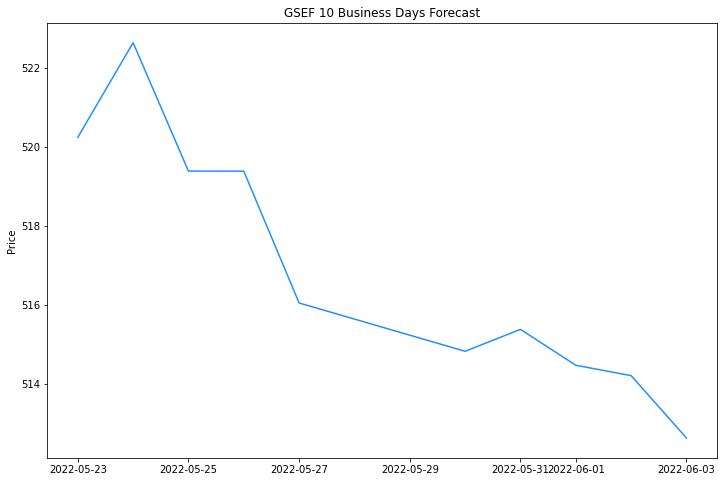

In [15]:
plt.figure(figsize=(12, 8))

plt.plot(existing_with_forecast['Date'][-10:], existing_with_forecast['Close'][-10:], color='dodgerblue')

#ax1.set_xticks(np.arange(len(existing_with_forecast['Date'][-10:])))

#plt.yticks(np.arange(existing_with_forecast['Close'][-10:]))

plt.ylabel('Price')

plt.title('GSEF 10 Business Days Forecast')

forecast_chart= 'gsef_output/gsef_10_day_forecast.png'

import os
if os.path.exists(forecast_chart):
  os.remove(forecast_chart)
else:
  print("The Forecast chart didn't exist and it has been created.")

plt.savefig('gsef_output/gsef_10_day_forecast.png', dpi=100)

#plt.show()

## Time Elapsed

In [16]:
# Calculate and print the time elapsed to run ETL process and the date and time of the latest run
time_elapsed = timeit.default_timer() - start_time

time_elapsed_minutes = int((time_elapsed % 3600) // 60)

time_elapsed_seconds = int(time_elapsed % 60)

now = datetime.datetime.now()

print("\n Success! Your GSEF forecast has been updated in {} minutes and {} seconds on {}".format(time_elapsed_minutes, time_elapsed_seconds, now.strftime("%Y-%m-%d %H:%M:%S")))


 Success! Your GSEF forecast has been updated in 12 minutes and 10 seconds on 2022-05-23 23:40:54
